In [ ]:
## Finding the percolation packing fraction
# at what min packing fraction do we get percolation

In [321]:
import os
import sys
import glob
import platform
from   tqdm              import tqdm # type: ignore
from   pathlib           import Path
import matplotlib                    # type: ignore
import numpy             as     np   # type: ignore
import matplotlib.pyplot as     plt  # type: ignore
import src.readFiles as readFiles
import math

system_platform = platform.system()
if system_platform == 'Darwin':  # macOS
    topDir = Path("/Volumes/rahul_2TB/high_bidispersity/new_data/")
    figSavePath = Path("/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/peroclation")
elif system_platform == 'Linux':
    topDir = Path("/media/rahul/rahul_2TB/high_bidispersity/new_data/")
    figSavePath = Path("/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/peroclation")
else:
    raise OSError(f"Unsupported OS: {system_platform}")

In [399]:
def kneighborfig(dataname, frame, k=3):
    fig, ax  = plt.subplots(1, 1, figsize=(5,5))
    
    parPath  = glob.glob(f'{dataname}/{parFile}')[0]
    parLines = open(parPath).readlines()

    parList   = readFiles.readParFile(open(parPath))
    intPath   = open(glob.glob(f'{dataname}/{interactionFile}')[0])
    intList   = readFiles.interactionsList(intPath)
    frameList = intList[frame]

    p1 = frameList[:,0].astype(int)
    p2 = frameList[:,1].astype(int)
    contState = frameList[:,10]

    contMat = np.zeros((npp, npp), dtype=np.uint8)
    mask    = contState == 2
    contMat[p1[mask], p2[mask]] = 1
    contMat[p2[mask], p1[mask]] = 1
    
    px = parList[frame][:, 2]
    pz = parList[frame][:, 3]
    pr = parList[frame][:, 1]
    
    totContacts = contMat.sum(axis=0)
    
    # plotting all particles 
    for i in range(len(px)):
        if totContacts[i] >= k:
            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#ff0000', fill=True, edgecolor='none') #083d5f
        else:
            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#8A9BA8', fill=True, edgecolor='none')
        ax.add_artist(circle)
        
    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_title(fr'$\mathbf{{\phi = {phi},\; \delta = {ar},\; \gamma = {frame/100:.2f},\; k = 3}}$', fontsize=16)
    
def kclusters(contmatrix, frame, k=3):
    cordination = contMat.sum(axis=1)
    #neighbors   = {i: np.where(contMat[i] == 1)[0] for i in range(contMat.shape[0])}
    knodes      = set(np.where(cordination >= k)[0])
    neighbors   = {i: [j for j in np.where(contMat[i] == 1)[0] 
                   if j in knodes] for i in knodes}
    
    visited  = set()
    clusters = []

    for node in knodes:
        if node not in visited:
            stack = [node]
            cluster = set()

            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    cluster.add(current)
                    stack.extend(neighbors[current])

            clusters.append(cluster)
            
    return clusters

def clusterSpan(positions, box_length):
    ref = positions[0]
    shifted = (positions - ref + box_length/2) % box_length - box_length/2
    return shifted.max() - shifted.min()

In [410]:
# Simulation parameters
npp    = 1000
phi    = 0.74 #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = 1.4  #, 1.4, 1.8, 2.0, 4.0]
vr     = '0.5'
numRun = 1
off    = 100

# Particles data file
parFile = 'par_*.dat' 
intFile = 'int_*.dat'
rigFile = 'rig_*.dat'

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True

# Frame details
# startFrame = 100
# endFrame   = 201
kspanning   = set()
rigspanning = set()

dataname = f"{topDir}/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
if os.path.exists(dataname):
    parPath  = glob.glob(f'{dataname}/{parFile}')[0]
    parLines = open(parPath).readlines()
    parList  = readFiles.readParFile(open(parPath))
    
    intPath  = open(glob.glob(f'{dataname}/{interactionFile}')[0])
    intList  = readFiles.interactionsList(intPath)
    
    rigFilePath   = glob.glob(f'{dataname}/{rigFile}')
    rigidFile     = open(rigFilePath[0])
    rigClusterIDs = readFiles.rigList(rigidFile)
    
    # box dimensions
    Lx = float(parLines[3].split()[2]) 
    Lz = float(parLines[3].split()[2])

    newLx = Lx + 2*ar
    newLz = Lz + 2*ar
    
    for frame in tqdm(range(off, off+125), desc="Processing frames"):
        #frame =1000
        frameList = intList[frame]

        p1 = frameList[:,0].astype(int)
        p2 = frameList[:,1].astype(int)
        contState = frameList[:,10]

        contMat = np.zeros((npp, npp), dtype=np.uint8)
        mask    = contState == 2
        contMat[p1[mask], p2[mask]] = 1
        contMat[p2[mask], p1[mask]] = 1
        
        clusters = kclusters(contMat, frame, k=3)
        
        for group in clusters:
            px = parList[frame][list(group), 2]
            pz = parList[frame][list(group), 3]
            
            spanx = clusterSpan(px, Lx)
            spanz = clusterSpan(pz, Lz)
            #if spanz >= Lz - ar:
            if spanx >= Lx - ar and spanz >= Lz - ar:
                kspanning.add(frame)
        
        #for group in clusterIDs:
        for rigIDs in rigClusterIDs[frame]:
            px = parList[frame][rigIDs, 2]
            pz = parList[frame][rigIDs, 3]

            spanx = clusterSpan(px, Lx)
            spanz = clusterSpan(pz, Lz)

            if spanx >= Lx - ar and spanz >= Lz - ar:
                rigspanning.add(frame)

Processing frames: 100%|█████████████████████| 125/125 [00:00<00:00, 518.61it/s]


In [329]:
len(rigspanning)

0

In [382]:
len(kspanning)

0

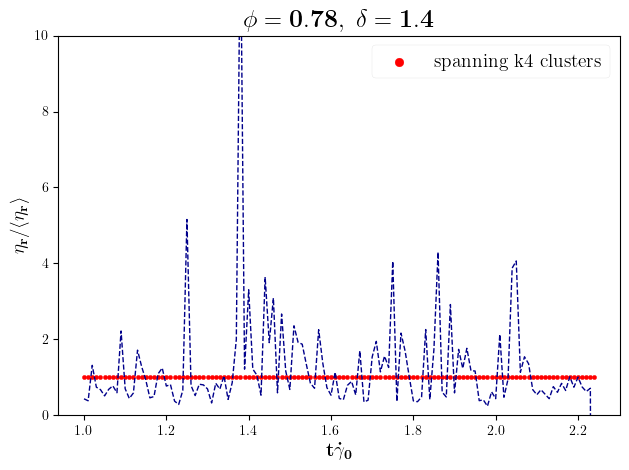

In [388]:
datFile = glob.glob(f'{dataname}/data_*.dat')[0]
data    = np.loadtxt(open(datFile))
visc    = data[off:off+300, 3]
strain  = data[off:off+300, 1]

plt.plot(strain, visc/np.mean(visc), color='darkblue', linestyle='--', linewidth=1)
plt.scatter(np.array(list(kspanning))/100, np.ones(len(list(kspanning))), color='red', s=10,
           label='spanning k4 clusters') #rig clusters

plt.legend(fontsize=14, markerscale=2.0,)
plt.xlabel(r'$\mathbf{t \dot \gamma_0}$',fontsize=14)
plt.ylabel(r'$\mathbf{\eta_r/\langle \eta_r \rangle}$',fontsize=14)
plt.title(fr'$\mathbf{{\phi = {phi}, \; \delta = {ar}}}$',fontsize=18)
#plt.yscale('log')
plt.ylim([0, 10])
plt.savefig(f'{figSavePath}/spanning_k3_phi_{phi}_ar_{ar}.pdf', dpi=400)

plt.show()

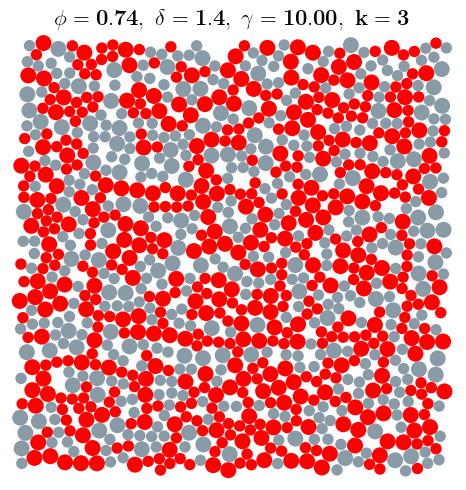

In [412]:
#dataname = f"{topDir}/NP_{1000}/phi_{0.76}/ar_{1.4}/Vr_{0.5}/run_{1}"
kneighborfig(dataname, frame=1000, k=3)
plt.savefig(f'{figSavePath}/spanning_k3_fig_phi_{phi}_ar_{ar}.pdf', dpi=400)
plt.show()

In [293]:
rigspanning

set()

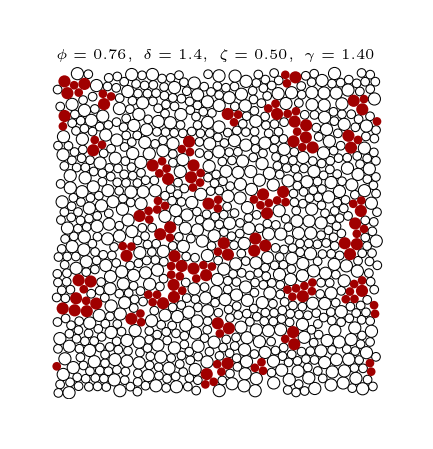

In [409]:
makerigsnapshot(npp, phi=0.76, frame =140, ar=1.4, vr = '0.5', run = 1)
plt.savefig(f'{figSavePath}/spanning_rig_fig_phi_{phi}_ar_{ar}.pdf', dpi=400)
plt.show()

In [54]:
fricparts = np.where(totContacts > 0)[0]
fricparts[0]

np.int64(2)

In [117]:
clusters = kclusters(parPath, contMat, frame, k=1)

In [118]:
len(clusters)

248

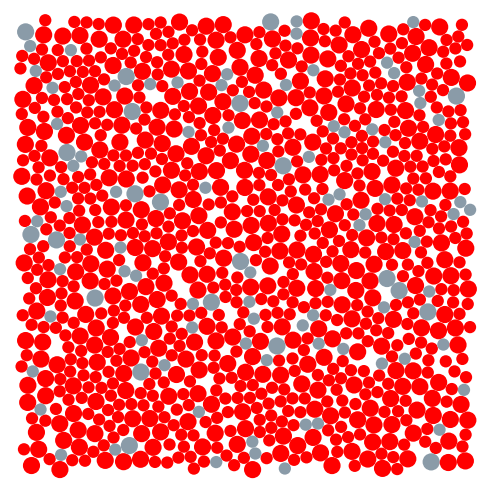

In [119]:
kneighborfig(parPath, contMat, frame, k=1)

In [122]:
parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
#clusters = kclusters(parPath, contMat, frame, k=3)

parList = readFiles.readParFile(parPath)
    
px = parList[frame][:, 2]
pz = parList[frame][:, 3]
pr = parList[frame][:, 1]

k =1

totContacts = contMat.sum(axis=0)
neighbors   = {i: np.where(contMat[i] == 1)[0] for i in range(contMat.shape[0])}
kparts      =  np.where(totContacts >= k)[0] #removing rattlers (zero contact keys)

kclust = [[kparts[0]]]

# plotting all particles 
for i, index in enumerate(kparts[1:]):
    match = False
    for ii, cluster in enumerate(kclust):
        if any(n in cluster for n in neighbors[index]):
            kclust[ii].append(index)
            match = True
            break

    if not match:
        kclust.append([index])

In [ ]:
parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
#clusters = kclusters(parPath, contMat, frame, k=3)

parList = readFiles.readParFile(parPath)
    
px = parList[frame][:, 2]
pz = parList[frame][:, 3]
pr = parList[frame][:, 1]

k =1

totContacts = contMat.sum(axis=0)
neighbors   = {i: np.where(contMat[i] == 1)[0] for i in range(contMat.shape[0])}
kparts      =  np.where(totContacts >= k)[0] #removing rattlers (zero contact keys)

kclust = []

for i, index in enumerate(kparts):
    match = False
    for ii, cluster in enumerate(kclust):
        if any(n in cluster for n in neighbors[index]):
            kclust[ii].append(index)
            match = True
            break

    if not match:
        kclust.append([index])

group = True
while group
    for i, cluster in kclust:
        for ii, index in cluster:
            if any(n in neighbor[index] for n in kclust[i]):
                kclust[i] = kclust[i] + kclust[i+1]
                del kclust[i+1]
                
    

In [135]:
import numpy as np

k = 1
cordination = contMat.sum(axis=1)
kparts = set(np.where(cordination >= k)[0])

neighbors = {}
for i in kparts:
    neighbors[i] = [j for j in np.where(contMat[i] == 1)[0] if j in eligible]

visited = set()
clusters = []

for node in neighbors:
    if node not in visited:
        stack = [node]
        cluster = set()

        while stack:
            current = stack.pop()
            if current not in visited:
                visited.add(current)
                cluster.add(current)
                stack.extend(neighbors[current])

        clusters.append(cluster)

In [148]:
import numpy as np

k = 1
cordination = contMat.sum(axis=1)
neighbors   = {i: np.where(contMat[i] == 1)[0] for i in range(contMat.shape[0])}
knodes      = set(np.where(cordination >= k)[0])

# neighbors = {}
# for i in kparts:
#     neighbors[i] = [j for j in np.where(contMat[i] == 1)[0] if j in eligible]


visited = set()
clusters = []

for node in knodes:
    if node not in visited:
        stack = [node]
        cluster = set()

        while stack:
            current = stack.pop()
            if current not in visited:
                visited.add(current)
                cluster.add(current)
                stack.extend(neighbors[current])

        clusters.append(cluster)

In [147]:
len(clusters)

1

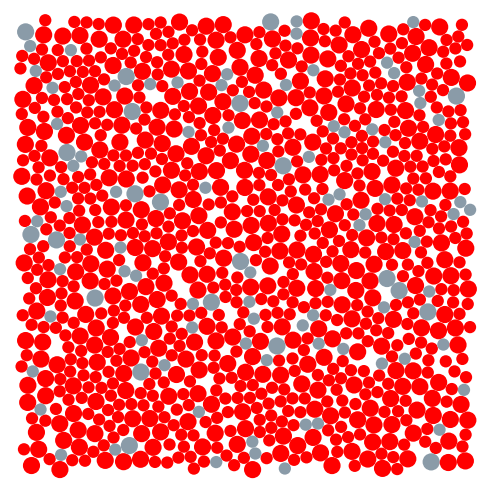

In [137]:
kneighborfig(open(parPath), contMat, frame, k=1)

In [112]:
kparts

array([ 43, 203, 307, 658, 688, 702, 706, 734, 796, 797, 799, 800, 801,
       822, 848, 863, 881, 889, 931, 932, 972])

In [114]:
any(n in [863] for n in neighbors[889])

True

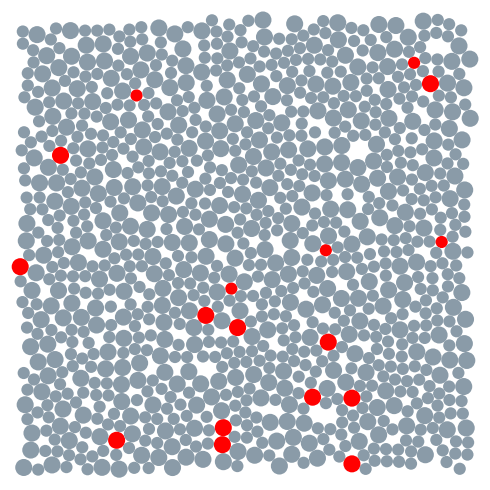

In [73]:
parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
kneighborfig(parPath, contMat, frame, k=5)

In [403]:
## make rig snapshot
# import matplotlib
# matplotlib.use("module://matplotlib_inline.backend_inline")
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
%matplotlib inline

# Particles data file.
parFile = 'par_*.dat'
rigFile = 'rig_*.dat'

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "text.usetex": True,
    "figure.autolayout": True,
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "font.size":        10,
    "xtick.labelsize":  10,
    "ytick.labelsize":  10,
    "patch.linewidth":  .2,
    "lines.markersize":  5,
    "hatch.linewidth":  .2
})
plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
# matplotlib.use('Agg')

def makerigsnapshot(npp, phi, frame, ar =1.4, vr = '0.5', run = 1):
    phii = phi
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    dataname = topDir / f"NP_{npp}/phi_{phii}/ar_{ar}/Vr_{vr}"
    if os.path.exists(dataname):
        particleFile  = open(glob.glob(f'{dataname}/run_{run}/{parFile}')[0])
        parLines      = particleFile.readlines()
        particlesList = readFiles.readParFile(particleFile)

        rigFilePath   = glob.glob(f'{dataname}/run_{run}/{rigFile}')
        if not rigFilePath:
            print(f"Error: {rigFile} not found at {dataname}/run_{run}")
            sys.exit(1)
        rigidFile     = open(rigFilePath[0])
        rigClusterIDs = readFiles.rigList(rigidFile)
        clusterIDs    = [[np.nan] if len(samplelist[0]) < 2 else list({int(num) for sublist in samplelist for num in sublist}) for samplelist in rigClusterIDs]

        # Box dimensions.
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        px = particlesList[frame][:,2]
        pz = particlesList[frame][:,3]
        pr = particlesList[frame][:,1]

        # Setting up axis and box walls.
        fig, ax = plt.subplots(1, 1, figsize=(1,1), dpi = 500)
        newLx   = Lx + 2*np.max(pr)
        newLz   = Lz + 2*np.max(pr)

        allPart      = particlesList[frame][:,0]
        rigidPart    = clusterIDs[frame]
        notRigidPart = allPart[np.isin(allPart, rigidPart) == False]

        ax.clear()
        for index in notRigidPart:
            index  = int(index)
            circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='w', edgecolor='k', linewidth=0.15, zorder=1)
            ax.add_artist(circle)
        
        for index in rigidPart:
            circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='#A00000', edgecolor=None, zorder=2)
            ax.add_artist(circle)

        ax.set_xlim([-(newLx/2),(newLx/2)])
        ax.set_ylim([-(newLz/2),(newLz/2)])
        ax.axis('off')
        ax.set_aspect('equal')
        ax.set_title(fr'$\phi = {phii}, \;\delta = {ar}, \; \zeta = {float(vr):.2f},\; \gamma = {frame/100:.2f}$', 
                     fontsize=2, pad=1, fontweight='bold', x=0.5)

        plt.tight_layout()

# Numba-accelerated function for periodic max distance
#@njit
def periodic_cluster_span(positions, box_length):
    ref = positions[0]
    shifted = (positions - ref + box_length/2) % box_length - box_length/2
    return shifted.max() - shifted.min()

In [9]:
## Identify percolating rig clusters

# Simulation parameters.
npp     = 1000
phi     = 0.76 #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar      = 1.4 #, 1.4, 1.8, 2.0, 4.0]
vr      = '0.5'
numRun  = 1
off     = 100

# Particles data file.
parFile  = 'par_*.dat'
rigFile  = 'rig_*.dat'
frigFile = 'F_rig.txt'

#phii = phi[j]
phii = '{:.3f}'.format(phi) if len(str(phi).split('.')[1]) > 2 else '{:.2f}'.format(phi)
dataname = topDir / f"NP_{npp}/phi_{phii}/ar_{ar}/Vr_{vr}"
if os.path.exists(dataname):
    particleFile  = open(glob.glob(f'{dataname}/run_{numRun}/{parFile}')[0])
    parLines      = particleFile.readlines()
    particlesList = readFiles.readParFile(particleFile)

    rigFilePath   = glob.glob(f'{dataname}/run_{numRun}/{rigFile}')
    frigFilePath  =  glob.glob(f'{dataname}/run_{numRun}/{frigFile}')
    if not rigFilePath:
        print(f"Error: {rigFile} not found at {dataname}/run_{numRun}")
        sys.exit(1)
    rigidFile     = open(rigFilePath[0])
    rigClusterIDs = readFiles.rigList(rigidFile)
    frig          = np.loadtxt(open(frigFilePath[0]))
    
    # Box dimensions.
    Lx = float(parLines[3].split()[2]) 
    Lz = float(parLines[3].split()[2])

    percframes = [] 
    #spanlist = []
    for frame in tqdm(range(off, len(particlesList)), desc="Inner loop", leave=False):
        #print(frame)
        px = particlesList[frame][:,2]
        pz = particlesList[frame][:,3]
        pr = particlesList[frame][:,1]

        for rigpart in rigClusterIDs[frame]:
            posx = px[rigpart]
            posz = pz[rigpart]
            
            span = periodic_cluster_span(posz, Lz)
            #spanlist.append(span)
            if span >= Lz - ar:
                percframes.append(frame)

# show frames with percolating rig clusters
np.array(percframes)

array([ 229,  231,  258,  280,  284,  285,  286,  331,  363,  364,  461,
        473,  474,  506,  507,  508,  539,  785,  786, 1158, 1159, 1160,
       1611, 1613, 1617, 1688])

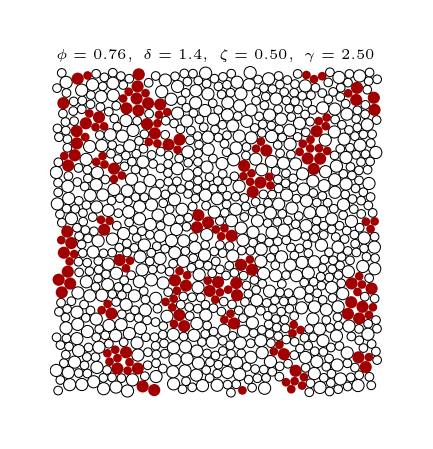

In [16]:
makerigsnapshot(1000, 0.76, frame =250, ar =1.4, vr = '0.5', run = 1)

In [18]:
np.mean(frig[percframes]/npp)

np.float64(0.7784615384615384)

In [91]:
## When percolation first appers in phi sweep

phim = np.array([[0.787, 0.788, 0.794 , 0.828],
                  [0.787, 0.787, 0.798 , 0.826],
                  [0.787, 0.787, 0.792, 0.807]])

# Simulation parameters.
npp      = 1000
phi      = [0.71, 0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8, 0.802, 0.82]
ar       = [1.0, 1.4, 2.0, 4.0]
vr       = ['0.25', '0.5', '0.75']
numRuns  = 2
off      = 100

# Particles data file.
parFile = 'par_*.dat'
rigFile = 'rig_*.dat'

print('When does the first percolation occur in packing fraction (phi and phim):')

for k in range(len(ar)):
    print('\n')
    for l in range(len(vr)):
        stop_outer = False
        for j in range(len(phi)):
            if stop_outer:
                break 
                
            phii = phi[j]
            phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
            for m in range(numRuns):
                dataname = topDir / f"NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{m+1}"
                if os.path.exists(dataname):
                    particleFile  = open(glob.glob(f'{dataname}/{parFile}')[0])
                    parLines      = particleFile.readlines()
                    particlesList = readFiles.readParFile(particleFile)
        
                    rigFilePath   = glob.glob(f'{dataname}/{rigFile}')
                    if not rigFilePath:
                        print(f"Error: {rigFile} not found at {dataname}")
                        sys.exit(1)
                    rigidFile     = open(rigFilePath[0])
                    rigClusterIDs = readFiles.rigList(rigidFile)
                    
                    # Box dimensions.
                    Lx = float(parLines[3].split()[2]) 
                    Lz = float(parLines[3].split()[2])
        
                    #for frame in tqdm(range(off, len(particlesList)), desc="Inner loop", leave=False):
                    for frame in range(off, len(particlesList)):
                        #print(frame)
                        px = particlesList[frame][:,2]
                        pz = particlesList[frame][:,3]
                        pr = particlesList[frame][:,1]
        
                        for rigpart in rigClusterIDs[frame]:
                            posx = px[rigpart]
                            posz = pz[rigpart]
                            
                            span = periodic_cluster_span(posz, Lz)
                            #spanlist.append(span)
                            if span >= Lz - ar[k]:
                                print(f'ar = {ar[k]}, vr = {vr[l]}, run = {m+1} --> {phii}, {(float(phii)/phim[l][k]):.4f}')
                                stop_outer = True
                                break 
                                
                        if stop_outer:
                            break

When does the first percolation occur in packing fraction (phi and phim):


ar = 1.0, vr = 0.25, run = 1 --> 0.76, 0.9657
ar = 1.0, vr = 0.5, run = 1 --> 0.76, 0.9657
ar = 1.0, vr = 0.75, run = 1 --> 0.76, 0.9657


ar = 1.4, vr = 0.25, run = 1 --> 0.76, 0.9645
ar = 1.4, vr = 0.5, run = 1 --> 0.76, 0.9657
ar = 1.4, vr = 0.75, run = 1 --> 0.76, 0.9657


ar = 2.0, vr = 0.25, run = 1 --> 0.76, 0.9572
ar = 2.0, vr = 0.5, run = 2 --> 0.76, 0.9524
ar = 2.0, vr = 0.75, run = 1 --> 0.76, 0.9596


ar = 4.0, vr = 0.25, run = 1 --> 0.785, 0.9481
ar = 4.0, vr = 0.5, run = 1 --> 0.785, 0.9504
ar = 4.0, vr = 0.75, run = 1 --> 0.77, 0.9542


In [89]:
phii

'0.76'

In [75]:
## Identify percolating rig clusters

# Simulation parameters.
npp     = 1000
phi     = [0.76] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar      = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr      = ['0.5']
numRun  = 1
off     = 100

# Particles data file.
parFile = 'par_*.dat'
rigFile = 'rig_*.dat'

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = topDir / f"NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}"
            if os.path.exists(dataname):
                particleFile  = open(glob.glob(f'{dataname}/run_{numRun}/{parFile}')[0])
                parLines      = particleFile.readlines()
                particlesList = readFiles.readParFile(particleFile)

                rigFilePath   = glob.glob(f'{dataname}/run_{numRun}/{rigFile}')
                if not rigFilePath:
                    print(f"Error: {rigFile} not found at {dataname}/run_{numRun}")
                    sys.exit(1)
                rigidFile     = open(rigFilePath[0])
                rigClusterIDs = readFiles.rigList(rigidFile)
                
                # Box dimensions.
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                percframes = [] 
                #spanlist = []
                for frame in tqdm(range(off, len(particlesList)), desc="Inner loop", leave=False):
                    #print(frame)
                    px = particlesList[frame][:,2]
                    pz = particlesList[frame][:,3]
                    pr = particlesList[frame][:,1]

                    for rigpart in rigClusterIDs[frame]:
                        posx = px[rigpart]
                        posz = pz[rigpart]
                        
                        span = periodic_cluster_span(posz, Lz)
                        #spanlist.append(span)
                        if span >= Lz - ar[k]:
                            percframes.append(frame)

# show frames with percolating rig clusters
np.array(percframes)